## Import libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.pipeline import Pipeline
from sqlalchemy import types as sql_types
from txtools.normalizer import TextNormalizer, clean_text
from txtools.utils import LangDetector
from txtools.similarity import Similarity
from db_utils import connection

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ciscodelgado/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ciscodelgado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ciscodelgado/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Retrieving leads
I will get a sample of leads from Emagister database gererated in the last year. The sample table `leads` contains 25000 leads.

In [139]:
leads_query = '''SELECT user_id,
    course_id,
    course_title,
    course_description,
    course_category,
    center,
    created_on
FROM leads
ORDER BY created_on DESC
'''

leads_df = pd.read_sql_query(leads_query, con=connection())

In [140]:
leads_df.head()

,user_id,course_id,course_title,course_description,course_category,center,created_on
0,f6cc096c484223cb6e685b2040a94503,170565193,Hotel & Catering Management,Wouldn’t it be great to put yourself into the ...,Catering,International Open Academy,2019-12-26 22:08:19
1,e357c31909d5d2f2be3a21422f85041c,170563091,Complementary Therapies - Level 2,This course will provide an introduction to th...,Alternative Health,Hugh Baird College,2019-12-26 21:55:14
2,1fded1ec757c0e13c34cb2374a658281,170418102,CompTIA A+ Certification Online Course,Are you looking to advance in your professiona...,Network Administration,Distance Learning Centre,2019-12-26 21:54:31
3,f6cc096c484223cb6e685b2040a94503,170265579,Part Time Survival Cooking,This course aims to develop the learners knowl...,Cookery,Telford College Of Arts and Technology,2019-12-26 21:52:50
4,217408ee6a840420049089c1299f3800,170418100,Complete child care course,Approximate Study Time: 100 Hours (Self Study...,Child Care,Distance Learning Centre,2019-12-26 21:46:18


### Search for duplicated
Duplicated leads, in this case is when a user generates more than one lead into the same course

In [148]:
leads_df.duplicated(['user_id', 'course_id']).sum()

235

I will remove the duplicates keeping the first lead generated by the user, that's the one that was created earlier.

In [149]:
leads_df.drop_duplicates(['user_id', 'course_id'], inplace=True, keep='last')

In [150]:
leads_df.duplicated(['user_id', 'course_id']).sum()

0

### Search for missing values

In [153]:
leads_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39765 entries, 0 to 39999
Data columns (total 7 columns):
user_id               39765 non-null object
course_id             39765 non-null object
course_title          39765 non-null object
course_description    38236 non-null object
course_category       39765 non-null object
center                39765 non-null object
created_on            39765 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 2.4+ MB


There are 1529 leads to courses without descriptions

In [156]:
leads_df[leads_df['course_description'].isnull()]['course_id'].nunique()

653

Or 653 courses without description. I will keep this rows in the dataframe because the information provided by a lead-course pair is very valuable even if the course has no description.

### Convert `course_id` column type to string

In [158]:
leads_df['course_id'] = leads_df['course_id'].astype(str)

In [159]:
leads_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39765 entries, 0 to 39999
Data columns (total 7 columns):
user_id               39765 non-null object
course_id             39765 non-null object
course_title          39765 non-null object
course_description    38236 non-null object
course_category       39765 non-null object
center                39765 non-null object
created_on            39765 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 2.4+ MB


## Retrieving reviews
The reviews come from the Emagister database and are a sample of those that have been made in the last 18 months.

In [160]:
reviews_query = '''SELECT user_id,
    course_id,
    course_title,
    course_category,
    course_description,
    center,
    rating,
    created_on
FROM reviews
ORDER BY created_on DESC
'''

reviews_df = pd.read_sql_query(reviews_query, con=connection())

In [161]:
reviews_df.head()

,user_id,course_id,course_title,course_category,course_description,center,rating,created_on
0,2b8d8517932c25c11858c48b7563d1f0,170378812,SIA Bodyguard Training,Self-development,The SIA approved Close Protection course is th...,Clinton Training Ltd,6,2019-12-26 17:40:22
1,6c4962141ae920e56739fd36a1383333,170363242,NVQ Tiling courses - Free - Funded by Government,Construction Trades,"CSCS Skill Card. <br />Suitable for: Employed,...",Censura Consulting,10,2019-12-26 17:18:13
2,52d477c4ebcb10e3368a2fa396d97df7,170628943,Bachelor in Aviation Management,Energy and Utilities,Immerse yourself in the world of aviation mana...,IUBH University of Applied Sciences,10,2019-12-26 14:51:26
3,8921583e8a24ca92d0ae4b65d86d6c6a,170385895,Forensics,Police,Forensic science is a very exciting area as sh...,International Career Institute,10,2019-12-26 11:27:27
4,6c4962141ae920e56739fd36a1383333,170363242,NVQ Tiling courses - Free - Funded by Government,Construction Trades,"CSCS Skill Card. <br />Suitable for: Employed,...",Censura Consulting,10,2019-12-26 11:25:08


### Search for outliers in `rating` column

In [165]:
reviews_df['rating'].describe()

count    19160.000000
mean         9.301461
std          1.142509
min          2.000000
25%          8.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: rating, dtype: float64

There seems to be no outliers

### Search for duplicated rows

In [166]:
reviews_df.duplicated(['user_id', 'course_id']).sum()

185

There are 185 duplicated reviews. I will remove them keeping the first review made by the user.

In [167]:
reviews_df.drop_duplicates(['user_id', 'course_id'], inplace=True, keep='last')

In [168]:
reviews_df.duplicated(['user_id', 'course_id']).sum()

0

### Search for missing values

In [169]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18975 entries, 0 to 19159
Data columns (total 8 columns):
user_id               18975 non-null object
course_id             18975 non-null int64
course_title          18975 non-null object
course_category       18975 non-null object
course_description    18919 non-null object
center                18975 non-null object
rating                18975 non-null int64
created_on            18975 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 1.3+ MB


There are 56 reviews to courses without description.

In [171]:
reviews_df[reviews_df['course_description'].isnull()]['course_id'].nunique()

23

Or 23 courses without description. I will do the same as in the previous case. I will keep the rows to keep the information of each review.

### Convert `course_id` column type to string

In [172]:
reviews_df['course_id'] = reviews_df['course_id'].astype(str)

In [173]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18975 entries, 0 to 19159
Data columns (total 8 columns):
user_id               18975 non-null object
course_id             18975 non-null object
course_title          18975 non-null object
course_category       18975 non-null object
course_description    18919 non-null object
center                18975 non-null object
rating                18975 non-null int64
created_on            18975 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 1.3+ MB



### Computing the weighted average

In [174]:
def average_rating(row, df):
    course_id = row['course_id']
    
    df = df[df['course_id'] == course_id]
    avg_rating = df['rating'].mean()
    num_reviews = df.shape[0]
    
    return pd.Series([avg_rating, num_reviews],
                     index=['avg_rating', 'num_reviews'])


In [175]:
def get_c(df=reviews_df):
    df = df.drop_duplicates('course_id')
        
    return df['avg_rating'].mean()

In [176]:
reviews_avg_rating = reviews_df.apply(average_rating, axis=1, args=(reviews_df,))
reviews_df = pd.concat([reviews_df, reviews_avg_rating], axis=1)

reviews_df.head()

,user_id,course_id,course_title,course_category,course_description,center,rating,created_on,avg_rating,num_reviews
0,2b8d8517932c25c11858c48b7563d1f0,170378812,SIA Bodyguard Training,Self-development,The SIA approved Close Protection course is th...,Clinton Training Ltd,6,2019-12-26 17:40:22,6.000000,1.0
2,52d477c4ebcb10e3368a2fa396d97df7,170628943,Bachelor in Aviation Management,Energy and Utilities,Immerse yourself in the world of aviation mana...,IUBH University of Applied Sciences,10,2019-12-26 14:51:26,9.428571,7.0
3,8921583e8a24ca92d0ae4b65d86d6c6a,170385895,Forensics,Police,Forensic science is a very exciting area as sh...,International Career Institute,10,2019-12-26 11:27:27,10.000000,1.0
4,6c4962141ae920e56739fd36a1383333,170363242,NVQ Tiling courses - Free - Funded by Government,Construction Trades,"CSCS Skill Card. <br />Suitable for: Employed,...",Censura Consulting,10,2019-12-26 11:25:08,9.500000,4.0
5,6c4962141ae920e56739fd36a1383333,170567406,Level 2 Diploma in Wall and Floor Tiling,Construction Trades,Level 2 Diploma in Wall and Floor Tiling\n« Re...,Hackney Community College,10,2019-12-26 11:19:59,9.000000,2.0


In [177]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18975 entries, 0 to 19159
Data columns (total 10 columns):
user_id               18975 non-null object
course_id             18975 non-null object
course_title          18975 non-null object
course_category       18975 non-null object
course_description    18919 non-null object
center                18975 non-null object
rating                18975 non-null int64
created_on            18975 non-null datetime64[ns]
avg_rating            18975 non-null float64
num_reviews           18975 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 1.6+ MB


In [178]:
def weighted_rating_average(row, C, m):
    score = (row['avg_rating'] * row['num_reviews'] + C * m) / (row['num_reviews'] + m)
    
    return pd.Series(score, index=['weighted_rating_average'])


In [179]:
C = get_c(reviews_df)

rating_average_s = reviews_df.apply(weighted_rating_average, axis=1, args=(C, 50))

reviews_df = pd.concat([reviews_df, rating_average_s], axis=1)

In [180]:
reviews_df['num_reviews'] = reviews_df['num_reviews'].astype(int)

In [181]:
reviews_df.head()

,user_id,course_id,course_title,course_category,course_description,center,rating,created_on,avg_rating,num_reviews,weighted_rating_average
0,2b8d8517932c25c11858c48b7563d1f0,170378812,SIA Bodyguard Training,Self-development,The SIA approved Close Protection course is th...,Clinton Training Ltd,6,2019-12-26 17:40:22,6.000000,1,9.195609
2,52d477c4ebcb10e3368a2fa396d97df7,170628943,Bachelor in Aviation Management,Energy and Utilities,Immerse yourself in the world of aviation mana...,IUBH University of Applied Sciences,10,2019-12-26 14:51:26,9.428571,7,9.280282
3,8921583e8a24ca92d0ae4b65d86d6c6a,170385895,Forensics,Police,Forensic science is a very exciting area as sh...,International Career Institute,10,2019-12-26 11:27:27,10.000000,1,9.274040
4,6c4962141ae920e56739fd36a1383333,170363242,NVQ Tiling courses - Free - Funded by Government,Construction Trades,"CSCS Skill Card. <br />Suitable for: Employed,...",Censura Consulting,10,2019-12-26 11:25:08,9.500000,4,9.277334
5,6c4962141ae920e56739fd36a1383333,170567406,Level 2 Diploma in Wall and Floor Tiling,Construction Trades,Level 2 Diploma in Wall and Floor Tiling\n« Re...,Hackney Community College,10,2019-12-26 11:19:59,9.000000,2,9.249539


## Create courses dataframe

I will create a dataframe of unique courses from the reviews and leads dataframes

In [229]:
course_info = ['course_id', 'course_title', 'course_description', 'course_category', 'center']

courses_from_leads = leads_df[course_info].drop_duplicates('course_id')
courses_from_reviews = reviews_df[course_info].drop_duplicates('course_id')

courses_df = pd.merge(courses_from_leads, courses_from_reviews,
                      left_on=course_info, 
                      right_on=course_info, 
                      how='outer')

courses_df.head()

,course_id,course_title,course_description,course_category,center
0,170565193,Hotel & Catering Management,Wouldn’t it be great to put yourself into the ...,Catering,International Open Academy
1,170563091,Complementary Therapies - Level 2,This course will provide an introduction to th...,Alternative Health,Hugh Baird College
2,170418102,CompTIA A+ Certification Online Course,Are you looking to advance in your professiona...,Network Administration,Distance Learning Centre
3,170265579,Part Time Survival Cooking,This course aims to develop the learners knowl...,Cookery,Telford College Of Arts and Technology
4,170418100,Complete child care course,Approximate Study Time: 100 Hours (Self Study...,Child Care,Distance Learning Centre


In [230]:
courses_df['course_id'].nunique()

17527

In [231]:
courses_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17527 entries, 0 to 17526
Data columns (total 5 columns):
course_id             17527 non-null object
course_title          17527 non-null object
course_description    16865 non-null object
course_category       17527 non-null object
center                17527 non-null object
dtypes: object(5)
memory usage: 821.6+ KB


Renaming the columns

In [232]:
courses_df.rename(columns={'course_id': 'id', 'course_title': 'title',
                          'course_description': 'description', 'course_category': 'category'},
                 inplace=True)

Cleaning text columns

In [234]:
courses_df['title'] = courses_df['title'].apply(clean_text)
courses_df['description'] = courses_df['description'].apply(lambda x: clean_text(x) if x else x)
courses_df['center'] = courses_df['center'].apply(clean_text)

### Content language

Sometimes the course descriptions are not in the correct language. I will detect the language, and I will discard the courses with the description in a language other than English.

In [236]:
lang_detector = LangDetector()
def get_lang(text):
    """ 
    Detects the language of a text
    
    :param text str: Text of which we want to know the language
                          
    :return str: Language ISO 639-1 code
    """
    if not text:
        return LangDetector.DEFAULT_LANGUAGE
    
    try: 
        return lang_detector.iso_639_1_code(text)
    except ValueError:
        return LangDetector.DEFAULT_LANGUAGE

In [242]:
courses_df['lang'] = courses_df['description'].apply(get_lang)

In [243]:
courses_df[courses_df['lang'] != 'en']

,id,title,description,category,center,lang
63,170232997,Introduction to Basic TIG Welding,To get basic skills in TIG welding. Suitable f...,Engineering,Allister Moore Weld Training Centre,xx
1786,170237397,Massage,To gain knowledge and skills on different kind...,Alternative Health,Stressolutions,xx
3372,170044771,Level 4 Award in Managing Food Safety in Catering,Suitable for: Designed for managers and superv...,Catering,Pure Training & Consultancy,da
3417,170173758,Emergency Medical Technician,Suitable for: Ski Patrollers or Mountain rescu...,Emergency Health,B.A.S.P. (British Association of Ski Patrollers),xx
5684,170197174,Full Time Level 3 BTEC in Countryside Management,Successful completion provides progression ont...,Environmental Management,BCA (Berkshire College of Agriculture),xx
8792,170282014,Full-time HNC Garden Design,Designed to provide skills and knowledge of ga...,Other Hobbies and Interests,Langside College,xx
9919,170393872,Sugarcraft Flowers,Suitable for: beginners /intermediate,Cookery,The Anticipation,xx
15856,170516966,Civil and Environmental Engineering with a yea...,AAA A-level Mathematics is required (or equiv...,Environmental Management,"Cardiff University, Wales",xx


In [244]:
courses_df = courses_df[courses_df['lang'] == 'en']
courses_df.drop('lang', axis=1, inplace=True)

/Users/ciscodelgado/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Create a categories dataframe

In [10]:
categories = courses_df['category'].unique()

In [13]:
categories_df = pd.DataFrame(categories, columns=['name'])

In [14]:
categories_df.head()

,name
0,Security Guarding
1,Engineering
2,Construction Trades
3,DIY
4,Biology and Biotechnology


### Save categories

In [16]:
types={'id': sql_types.INT(),
       'name': sql_types.VARCHAR(length=200)}

categories_df.to_sql('categories', con=connection(), index_label='id', if_exists='replace', dtype=types)

### Add category id to courses dataframe

In [29]:
def category_id(category_name):
    return categories_df[categories_df['name'] == category_name].index[0]
    

In [30]:
courses_df['category_id'] = courses_df['category'].apply(category_id)

In [31]:
courses_df.drop('category', inplace=True, axis=1)

In [33]:
courses_df.head()

,id,title,description,center,category_id
0,2365326,Level 2 Award in Security Guarding (SIA),Gain a qualification in Security Guarding to a...,Linx Security Training,0
1,2365342,Vapour Compression Cycle - Free Sample,"To explain the structure, purpose and operatio...",Star Learning Solutions,1
2,2365345,Refrigeration Fundamentals,The theoretical knowledge that the Refrigerati...,Star Learning Solutions,2
3,2365419,Basic Carpentry,Basic carpentry provides you with the skills t...,Building Skills Academy,2
4,2365431,Kitchen Worktop Cutting and Fitting,"Learn to design, cut and fit your own kitchen ...",Building Skills Academy,3


### Save courses

In [34]:
types={'id': sql_types.INT(), 
       'title':  sql_types.TEXT(),
       'description': sql_types.TEXT(),
       'category_id': sql_types.INT(),
       'center': sql_types.VARCHAR(length=100)}

courses_df.to_sql('courses', con=connection(), index=False, if_exists='replace', dtype=types)

## Save leads

In [247]:
leads_df = leads_df[['user_id', 'course_id', 'created_on']]

In [248]:
types = {'user_id': sql_types.CHAR(length=36),
         'course_id': sql_types.VARCHAR(length=12),
         'created_on': sql_types.DateTime()}

leads_df.to_sql('clean_leads', con=connection(), index=False, if_exists='replace', dtype=types)

## Save reviews

In [250]:
reviews_df = reviews_df[['user_id', 'course_id', 'num_reviews', 'rating', 'avg_rating', 'weighted_rating_average']]

In [251]:
types = {'user_id': sql_types.CHAR(length=36),
         'course_id': sql_types.VARCHAR(length=12),
         'rating': sql_types.INT(),
         'num_reviews': sql_types.INT(),
         'created_on': sql_types.DateTime()}

reviews_df.to_sql('clean_reviews', con=connection(), index=False, if_exists='replace', dtype=types)

## Create a course content similarity matrix

I will create a similarity matrix for courses content. I will use the title and the description to compare the courses with each other. In the matrix, columns and rows indexes will be the course id and the intersection will be the similarity between them. The range of values will be between 0 and 1, where 0 means totally different and 1 means that the content is identical.

In [94]:
def create_similarity_matrix(df, sample_len=None):
    """ 
    Creates a course similarity matrix
    
    :param df DataFrame: courses dataframe. Must include title and description columns
                          
    :return np.ndarray: An m x m matrix representing the course similarities, where m is the number of courses.
        Example of a similarity matrix:
        
         [[0.99999994 0.         0.13075474 0.02665992]
          [0.         1.         0.00812627 0.00331377]
          [0.13075474 0.00812627 1.         0.0069054 ]
          [0.02665992 0.00331377 0.0069054  1.        ]]
          
        rows and columns represents a course, the elements in the matrix, represent the similarity between them.
    """
    if not sample_len:
        course_content = df['title'].str.cat(df['description'], sep=' ').values
    else:
        course_content = df['title'].str.cat(df['description'], sep=' ').head(sample_len).values
    
    model = Pipeline([
        ('norm', TextNormalizer()),
        ('sim', Similarity())
    ])
    
    return model.fit_transform(course_content)
    

In [95]:
def create_similarity_df(df, min_similarity=0.5, sample_len=None):
    """
    Creates a course similarity DataFrame from a similarity matrix
    
    :param df DataFrame: Courses dataframe. Must include title and description columns
    :param min_similarity float: Minimum similarity to be included in DataFrame
    :param sample_len int: Maximum number of courses that will be included in the matrix
    
    :return DataFrame: a dataframe with following columns:
        a_course str: course id
        another_course str: course id
        similarity float: similarity between courses
    """
    sim_list = []
    sim_matrix = create_similarity_matrix(df, sample_len=sample_len)
    
    for idx, similarities in enumerate(sim_matrix):
        a_course_id = df.iloc[idx]['course_id']
        
        for idx_sims, sim_score in enumerate(similarities):
            if idx == idx_sims:
                continue

            if sim_score < min_similarity:
                continue

            another_course_id = df.iloc[idx_sims]['course_id']

            sim_list.append({'a_course': a_course_id, 
                             'another_course': another_course_id, 
                             'similarity': sim_score})

    return pd.DataFrame(sim_list)

I will create a similarity matrix with a sample of 50 courses

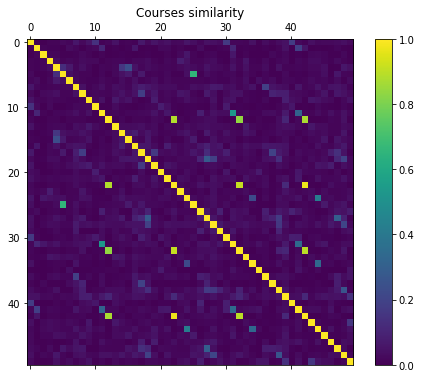

In [96]:
sims = create_similarity_matrix(courses_df, sample_len=50)

fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.matshow(sims, interpolation='nearest')
fig.colorbar(cax)
ax.set_title('Courses similarity')

plt.show();

The similarity dataframe will look like this:

In [97]:
sims_df_s50 = create_similarity_df(courses_df, sample_len=50)
sims_df_s50.head()

,a_course,another_course,similarity
0,170628400,170628401,0.658486
1,170040323,170040270,0.528053
2,170633067,170633063,0.882820
3,170633067,170633065,0.837449
4,170633067,170633072,0.871613


And now, I will create the similarities dataframe with the entire courses dataframe. <span style="color:red">**This process took approximately 8 hours on a MacBook pro (2.3 GHz Intel Core i5, 16 GB RAM)**</span>

In [ ]:
%%time
sims_df = create_similarity_df(courses_df)

In [31]:
sims_df.head()

,a_course,another_course,similarity
0,170648149,170648146,0.996332
1,170648149,170652710,0.505740
2,170367782,170642187,0.539035
3,170367782,170624005,0.557652
4,170601656,170617492,0.500261


In [ ]:
sims_df.to_csv('../data/courses_similarities.csv', index=False)

In [18]:
sims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126556 entries, 0 to 126555
Data columns (total 3 columns):
a_course          126556 non-null int64
another_course    126556 non-null int64
similarity        126556 non-null float64
dtypes: float64(1), int64(2)
memory usage: 2.9 MB


## Create the user item matrices

<span style="color:red">Docstring to be completed</span>

In [99]:
def create_user_item_matrix(df, group_columns=['user_id', 'course_id'], select_column='rating', allow_nulls=True):
    """
    Creates a user-item matrix DataFrame. Depending on the dataframe supplied it creates a
    user-item matrix from reviews of from leads
    
    :param group_columns list: Columns by which the data will be grouped
    :param select_column str: 
    :param allow_nulls bool: 
    
    :return DataFrame: a user-item matrix dataframe
    """
    columns = [column for column in group_columns]
    columns.extend([select_column])
    
    user_items = df[columns]
    
    user_by_course = user_items.groupby(group_columns)[select_column].max().unstack()
    
    if not allow_nulls:
        user_by_course = user_by_course.where(user_by_course.isnull(), other=1)
        user_by_course = user_by_course.fillna(0)
    
    return user_by_course

In [33]:
ratings_user_item_matrix = create_user_item_matrix(reviews_df)
leads_user_item_matrix = create_user_item_matrix(leads_df, select_column='course_title', allow_nulls=False)

Save the matrices to csv files

In [34]:
leads_user_item_matrix.to_csv('../data/leads_matrix.csv')
ratings_user_item_matrix.to_csv('../data/ratings_matrix.csv')

## Create user interactions dictionaries

<span style="color:red">
I will create two dictionaries with users interactions; a leads generated dictionary in which the keys will be the user ids and the values will be lists of courses that lead has generated.</span>

In [100]:
def create_user_leads_generated_dict():
    """
    Creates a dictionary with users
    
    :return dict:
    """
    leads_generated = dict()
    
    for user_id, _ in leads_user_item_matrix.iterrows():
        user_courses = leads_user_item_matrix.loc[user_id]
        leads_generated[user_id] = user_courses[leads_user_item_matrix.loc[user_id] == 1].index.values
        
    return leads_generated


def create_user_ratings_dict(min_num_rated=2):
    """
    Creates a dictionary with users
    
    :param int: minimum number of courses rated by user to be included in the dictionary
    
    :return dict:
    """
    ratings = dict()
    
    for user_id, _ in ratings_user_item_matrix.iterrows():
        user_courses = ratings_user_item_matrix.loc[user_id]
        user_ratings = user_courses[user_courses.notnull()].index.values
        if len(user_ratings) < min_num_rated:
            continue
            
        ratings[user_id] = user_ratings
        
    return ratings

Save the dictionaries to pickle files

In [109]:
rated_courses = create_user_ratings_dict()
with open('../data/rated_courses.pickle', 'wb') as handle:
    pickle.dump(rated_courses, handle)

generated_leads = create_user_leads_generated_dict()
with open('../data/generated_leads.pickle', 'wb') as handle:
    pickle.dump(generated_leads, handle)

## Create a users distance score table

In [102]:
def compute_euclidean_distance(a_user_id, another_user_id, user_item_matrix):
    """
    Computes the euclidean distance between users taking into account the rated courses
    
    :param a_user_id str: Id of a user
    :param another_user_id str: Id of another user
    :param user_item_matrix DataFrame: The reviews user-item matrix
    
    :return float: The eculidean distance between the users
    """
    a_user_courses = rated_courses[a_user_id]
    another_user_courses = rated_courses[another_user_id]
    
    similar_courses = np.intersect1d(a_user_courses,
                                     another_user_courses, 
                                     assume_unique=True)
    
    # there's no courses in common
    if len(similar_courses) == 0:
        return np.nan
    
    df = user_item_matrix.loc[(a_user_id, another_user_id), similar_courses]
    
    return np.linalg.norm(df.loc[a_user_id] - df.loc[another_user_id])


def create_distances_dataframe(user_item_matrix):
    """
    Creates a dataframe containing the euclidean distances between users
    
    :param user_item_matrix DataFrame: The ratings user-item matrix
    
    :return DataFrame: DataFrame containing the eculidean distances between the users
    """
    users = user_item_matrix.index.values
    distances = []

    for a_user_id in users:
        for another_user_id in users:
            if a_user_id == another_user_id:
                continue
            try: 
                distance = compute_euclidean_distance(a_user_id,
                                                      another_user_id,
                                                      ratings_user_item_matrix)
            except KeyError:
                continue

            if np.isnan(distance):
                continue

            distances.append({'a_user': a_user_id,
                              'another_user': another_user_id,
                              'eucl_dist': distance})

    return pd.DataFrame.from_dict(distances)

In [110]:
distances_df = create_distances_dataframe(ratings_user_item_matrix)

# Save the users distances to a pickle file
distances_df.to_pickle('../data/users_distances.pickle')
distances_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
a_user          22 non-null object
another_user    22 non-null object
eucl_dist       22 non-null float64
dtypes: float64(1), object(2)
memory usage: 608.0+ bytes


In [111]:
distances_df['eucl_dist'].value_counts()

0.000000    14
4.000000     4
2.828427     2
5.656854     2
Name: eucl_dist, dtype: int64

In [112]:
distances_df.shape

(22, 3)